#Libraries:

In [1]:
!pip install emoji
#pip install transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import csv
import emoji
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Reading Dataset:

In [4]:
train = pd.read_csv('/content/drive/MyDrive/NN/HW5/Train.csv')
val = pd.read_csv('/content/drive/MyDrive/NN/HW5/Val.csv')
test = pd.read_csv('/content/drive/MyDrive/NN/HW5/Test.csv')

In [5]:
train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [6]:
train_id = train['id']
train_tweet = train['tweet']
train_label = train['label']

val_id = val['id']
val_tweet = val['tweet']
val_label = val['label']

test_id = test['id']
test_tweet = test['tweet']
test_label = test['label']

train_label = train_label.map({"real": 1, "fake": 0})
val_label = val_label.map({"real": 1, "fake": 0})
test_label = test_label.map({"real": 1, "fake": 0})

#Pre-proccessing:

###1) Length processing:

In [7]:
train['tweet'] = train['tweet'].apply(lambda x: x[:128])

val['tweet'] = val['tweet'].apply(lambda x: x[:128])

test['tweet'] = test['tweet'].apply(lambda x: x[:128])

In [8]:
print(train['tweet'].apply(len).head())
print(val['tweet'].apply(len).head())
print(test['tweet'].apply(len).head())

0    128
1    128
2    128
3    128
4    128
Name: tweet, dtype: int64
0    110
1    128
2     76
3    128
4    128
Name: tweet, dtype: int64
0    128
1     38
2    124
3    128
4    128
Name: tweet, dtype: int64


###2) Emoji to text converter:

In [9]:
train['tweet'] = train['tweet'].apply(emoji.demojize)

val['tweet'] = val['tweet'].apply(emoji.demojize)

test['tweet'] = test['tweet'].apply(emoji.demojize)


In [10]:
print(train['tweet'][316])

2nd week of Jan :China: had mapped the genome &amp; shared it with WHO &amp; with wider :globe_showing_Europe-Africa:. We rapidly published a “how to” on buildin


###3) Tokenizing:

In [11]:
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_tweets(tweets, tokenizer, max_length=128):
    encoded_dict = tokenizer(
        tweets.tolist(),
        padding=True,
        add_special_tokens=True, # Add special tokens like [CLS] and [SEP]
        truncation=True,
        max_length=max_length,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt'
    )

    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    token_type_ids = encoded_dict['token_type_ids']

    return input_ids, attention_masks, token_type_ids

train_token_ids, train_attention_masks, train_token_type_ids = tokenize_tweets(train_tweet, tokenizer)
val_token_ids, val_attention_masks, val_token_type_ids = tokenize_tweets(val_tweet, tokenizer)
test_token_ids, test_attention_masks, test_token_type_ids = tokenize_tweets(test_tweet, tokenizer)

print("Train Attention Masks:", train_attention_masks)
print("Train Token Type IDs:", train_token_type_ids)
print("Validation Attention Masks:", val_attention_masks)
print("Validation Token Type IDs:", val_token_type_ids)
print("Test Attention Masks:", test_attention_masks)
print("Test Token Type IDs:", test_token_type_ids)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Train Attention Masks: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Train Token Type IDs: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Validation Attention Masks: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Validation Token Type IDs: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Test Attention Masks: tensor

In [12]:
print(train_token_ids[316])
print(train_attention_masks[316])
print(train_token_type_ids[316])

tensor([  101,  3416,  2733,  1997,  5553,   100,  2018, 17715,  1996, 13458,
         1004, 23713,  1025,  4207,  2009,  2007,  2040,  1004, 23713,  1025,
         2007,  7289,   100,  1012,  2057,  5901,  2405,  1037,  1523,  2129,
         2000,  1524,  2006,  2311,  1037,  7473,  2099,  3231,  2005,  1001,
         2522, 17258, 16147,  2013,  2256,  4256,  6845,  1999,   100,  1012,
         1999,  1996,  3822,  2733,  2040,  4453,  1004, 23713,  1025,  2211,
        21012,  2005,  9398,  4383,  2537,  1997,  2122,  5852,  1011,  1030,
         2852,  3064,  7352,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

# Model Implementation using Fine-Tuning:

###Implementing Dataset:

In [13]:
train_label = torch.tensor(train_label)
val_label = torch.tensor(val_label)
test_label = torch.tensor(test_label)

train_dataset = TensorDataset(train_token_ids, train_attention_masks, train_token_type_ids, train_label)

val_dataset = TensorDataset(val_token_ids, val_attention_masks, val_token_type_ids, val_label)

test_dataset = TensorDataset(test_token_ids, test_attention_masks, test_token_type_ids, test_label)

### BERT and CT-BERT Implementation:

### Model One:

In [15]:
import torch
import torch.nn as nn
from transformers import BertModel
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [15]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.fc(cls_output)
        probs = self.sigmoid(logits)
        return probs

#### Train:

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [18]:
model = BertClassifier(num_classes=2)

criterion = nn.CrossEntropyLoss()

epochs = 3
learning_rate = 5e-5
num_epochs = 3
batch_size = 32

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


model.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0

    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        running_train_correct += (predicted == labels).sum().item()
        running_train_total += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = running_train_correct / running_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0

    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs.squeeze(), labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_val_correct += (predicted == labels).sum().item()
            running_val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = running_val_correct / running_val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training finished!")

epochs = range(1, num_epochs + 1)


Epoch 1, Training Loss: 0.3955, Training Accuracy: 0.9171
Epoch 1, Validation Loss: 0.3521, Validation Accuracy: 0.9617
Epoch 2, Training Loss: 0.3439, Training Accuracy: 0.9688
Epoch 2, Validation Loss: 0.3386, Validation Accuracy: 0.9743
Epoch 3, Training Loss: 0.3325, Training Accuracy: 0.9808
Epoch 3, Validation Loss: 0.3376, Validation Accuracy: 0.9757
Training finished!


NameError: name 'plt' is not defined

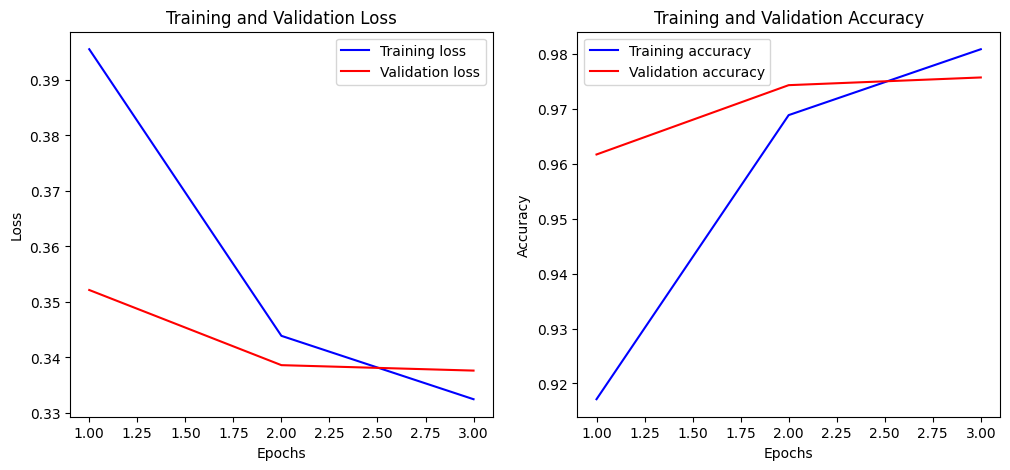

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### evaluate:

In [16]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


Using device: cuda


100%|██████████| 67/67 [00:12<00:00,  5.42it/s]


Accuracy: 0.9724
F1 Score: 0.9724


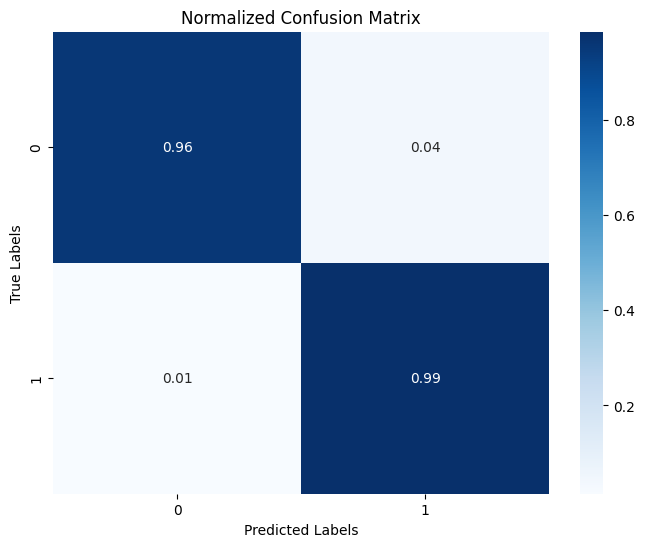

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model.to(device)
model.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model(input_ids, attention_mask, token_type_ids)
        _, predictions = torch.max(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

### Model Two:

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [20]:
class BertBiGRUClassifier(nn.Module):
    def __init__(self, num_classes=2, gru_hidden_size=128, gru_layers=1, dropout=0.3):
        super(BertBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.bigru = nn.GRU(input_size=768, hidden_size=gru_hidden_size,
                            num_layers=gru_layers, batch_first=True,
                            bidirectional=True, dropout=dropout)

        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

        self.sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = outputs.last_hidden_state

        gru_output, _ = self.bigru(last_hidden_state)

        hidden_state = torch.cat((gru_output[:, -1, :self.bigru.hidden_size], gru_output[:, 0, self.bigru.hidden_size:]), dim=-1)

        hidden_state = self.dropout(hidden_state)

        logits = self.fc(hidden_state)

        probs = self.sigmoid(logits)

        return probs

#### Train:

In [21]:
model2 = BertBiGRUClassifier(num_classes=2)

criterion = nn.CrossEntropyLoss()

epochs = 3
learning_rate = 5e-5
num_epochs = 3
batch_size = 32

optimizer = optim.Adam(model2.parameters(), lr=learning_rate)


model2.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model2.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0

    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model2(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        running_train_correct += (predicted == labels).sum().item()
        running_train_total += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = running_train_correct / running_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model2.eval()
    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0

    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            outputs = model2(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs.squeeze(), labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_val_correct += (predicted == labels).sum().item()
            running_val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = running_val_correct / running_val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training finished!")

epochs = range(1, num_epochs + 1)


Epoch 1, Training Loss: 0.4118, Training Accuracy: 0.9028
Epoch 1, Validation Loss: 0.3726, Validation Accuracy: 0.9402
Epoch 2, Training Loss: 0.3487, Training Accuracy: 0.9659
Epoch 2, Validation Loss: 0.3375, Validation Accuracy: 0.9757
Epoch 3, Training Loss: 0.3404, Training Accuracy: 0.9735
Epoch 3, Validation Loss: 0.3458, Validation Accuracy: 0.9678
Training finished!


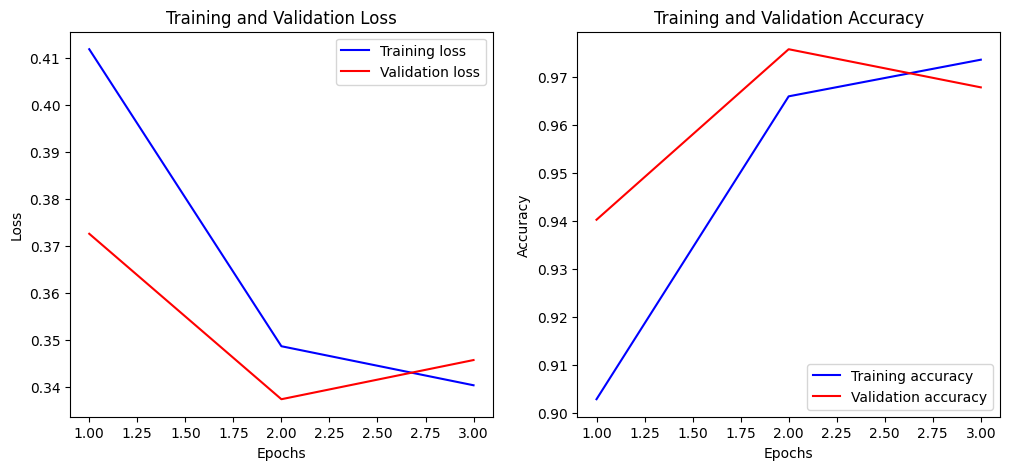

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Evaluate:

Using device: cuda


100%|██████████| 67/67 [00:14<00:00,  4.62it/s]


Accuracy: 0.9575
F1 Score: 0.9574


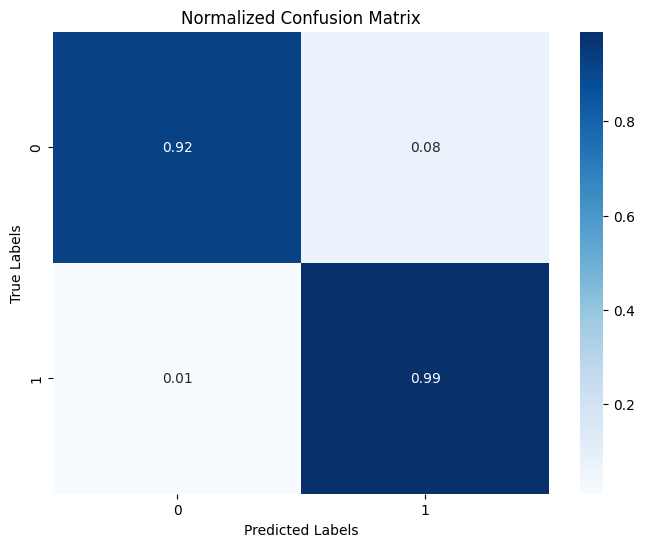

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model2.to(device)
model2.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model2(input_ids, attention_mask, token_type_ids)
        _, predictions = torch.max(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

### Model Three:

In [16]:
import torch
import torch.nn as nn
from transformers import BertModel

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [18]:
class CTBertBiGRUClassifier(nn.Module):
    def __init__(self, num_classes=2, gru_hidden_size=128, gru_layers=1, dropout=0.3):
        super(CTBertBiGRUClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert")

        self.bigru = nn.GRU(input_size=1024, hidden_size=gru_hidden_size,
                            num_layers=gru_layers, batch_first=True,
                            bidirectional=True, dropout=dropout)

        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

        self.sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = outputs.last_hidden_state

        gru_output, _ = self.bigru(last_hidden_state)

        hidden_state = torch.cat((gru_output[:, -1, :self.bigru.hidden_size], gru_output[:, 0, self.bigru.hidden_size:]), dim=-1)

        hidden_state = self.dropout(hidden_state)

        logits = self.fc(hidden_state)

        probs = self.sigmoid(logits)

        return probs


#### Train:

In [19]:
model3 = CTBertBiGRUClassifier(num_classes=2)

criterion = nn.CrossEntropyLoss()

epochs = 3
learning_rate = 5e-5
num_epochs = 3
batch_size = 32

optimizer = optim.Adam(model3.parameters(), lr=learning_rate)


model3.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model3.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0

    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model3(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        running_train_correct += (predicted == labels).sum().item()
        running_train_total += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = running_train_correct / running_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model3.eval()
    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0

    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            outputs = model3(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs.squeeze(), labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_val_correct += (predicted == labels).sum().item()
            running_val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = running_val_correct / running_val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training finished!")

epochs = range(1, num_epochs + 1)


config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Training Loss: 0.4271, Training Accuracy: 0.8900
Epoch 1, Validation Loss: 0.4673, Validation Accuracy: 0.8463
Epoch 2, Training Loss: 0.3816, Training Accuracy: 0.9321
Epoch 2, Validation Loss: 0.3489, Validation Accuracy: 0.9650
Epoch 3, Training Loss: 0.5685, Training Accuracy: 0.7442
Epoch 3, Validation Loss: 0.7579, Validation Accuracy: 0.5234
Training finished!


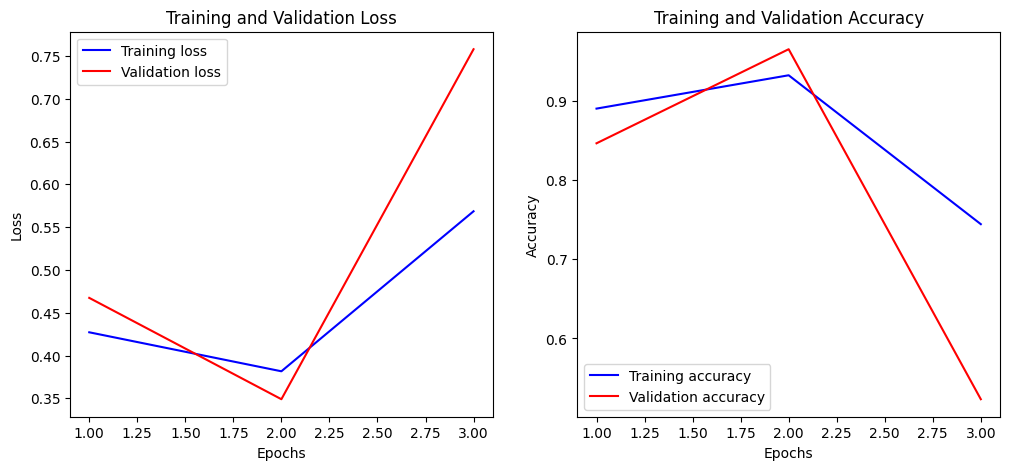

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Evaluation:

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model3.to(device)
model3.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model3(input_ids, attention_mask, token_type_ids)
        _, predictions = torch.max(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

Using device: cuda


NameError: name 'tqdm' is not defined

#Model Implementation with Feature-Based:

In [14]:
import torch.nn as nn
from transformers import BertModel
import torch

### Model One:

In [17]:
class BertClassifierFreeze(nn.Module):
    def __init__(self, num_classes=2):
        super(BertClassifierFreeze, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, num_classes)
        self.sigmoid = nn.Sigmoid()

        # Freezing BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.fc(cls_output)
        probs = self.sigmoid(logits)
        return probs

#### Train:

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [28]:
model4 = BertClassifierFreeze(num_classes=2)

criterion = nn.CrossEntropyLoss()

epochs = 3
learning_rate = 5e-5
num_epochs = 3
batch_size = 32

optimizer = optim.Adam(model4.parameters(), lr=learning_rate)


model4.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model4.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0

    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model4(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        running_train_correct += (predicted == labels).sum().item()
        running_train_total += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = running_train_correct / running_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model4.eval()
    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0

    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            outputs = model4(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs.squeeze(), labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_val_correct += (predicted == labels).sum().item()
            running_val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = running_val_correct / running_val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training finished!")

epochs = range(1, num_epochs + 1)


Epoch 1, Training Loss: 0.6632, Training Accuracy: 0.7153
Epoch 1, Validation Loss: 0.6332, Validation Accuracy: 0.7715
Epoch 2, Training Loss: 0.6236, Training Accuracy: 0.7791
Epoch 2, Validation Loss: 0.5962, Validation Accuracy: 0.8192
Epoch 3, Training Loss: 0.5950, Training Accuracy: 0.8072
Epoch 3, Validation Loss: 0.5696, Validation Accuracy: 0.8243
Training finished!


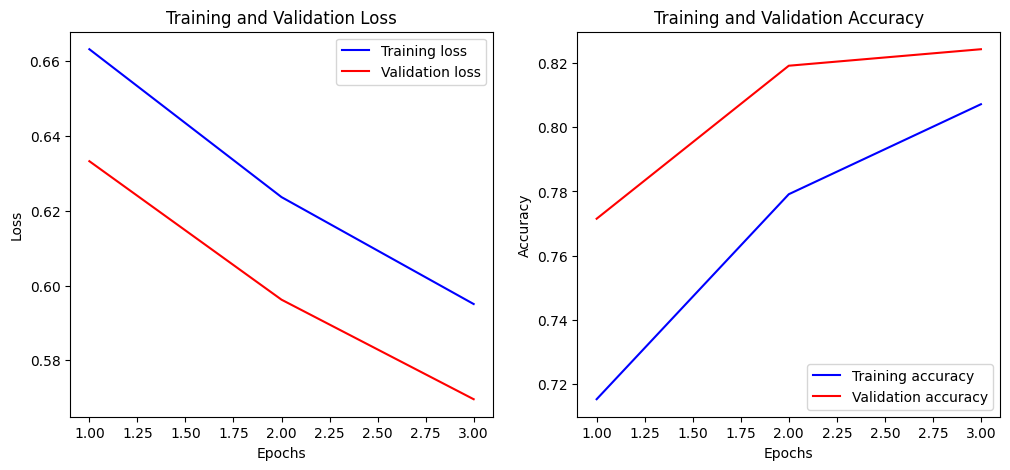

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Evaluation:

In [30]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

Using device: cuda


100%|██████████| 67/67 [00:13<00:00,  4.93it/s]


Accuracy: 0.8168
F1 Score: 0.8116


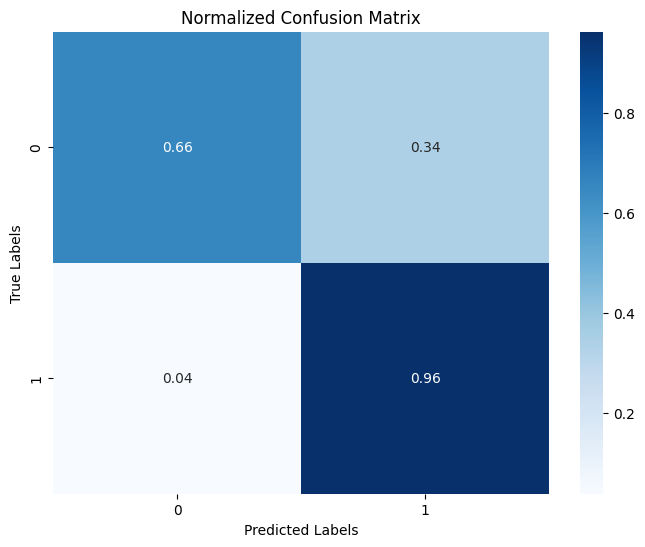

Sample 1:
True label: 0
Predicted label: 1
Input IDs: tensor([  101,  2343,  8398,  2356,  2054,  2002,  2052,  2079,  2065,  2002,
         2020,  2000,  4608,  1996, 21887, 23350, 16770,  1024,  1013,  1013,
         1056,  1012,  2522,  1013,  1017,  4168,  2860,  9825, 15378,  2072,
         1001,  6221, 24456,  2361,  1001, 21887, 23350,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model4.to(device)
model4.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model4(input_ids, attention_mask, token_type_ids)
        _, predictions = torch.max(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

incorrect_indices = np.where(all_preds != all_labels)[0]

num_samples_to_show = 2
for i in range(min(num_samples_to_show, len(incorrect_indices))):
    idx = incorrect_indices[i]
    sample = test_dataset[idx]

    input_ids, attention_mask, token_type_ids, label = sample

    print(f"Sample {i+1}:")
    print(f"True label: {label}")
    print(f"Predicted label: {all_preds[idx]}")
    print(f"Input IDs: {input_ids}")
    print(f"Attention Mask: {attention_mask}")
    print(f"Token Type IDs: {token_type_ids}")
    print("\n" + "-"*50 + "\n")

In [35]:
num_samples_to_show = 2
for i in range(min(num_samples_to_show, len(incorrect_indices))):
    idx = incorrect_indices[i]
    sample = test_dataset[idx]
    input_ids = sample[0]
    attention_mask = sample[1]
    token_type_ids = sample[2]
    label = sample[3]

    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)

    print(f"Sample {i+1}:")
    print(f"True label: {label}")
    print(f"Predicted label: {all_preds[idx]}")
    print(f"Original Text: {decoded_text}")
    print(f"Input IDs: {input_ids}")
    print(f"Attention Mask: {attention_mask}")
    print(f"Token Type IDs: {token_type_ids}")
    print("\n" + "-"*50 + "\n")

Sample 1:
True label: 0
Predicted label: 1
Original Text: president trump asked what he would do if he were to catch the coronavirus https : / / t. co / 3mewhusrzi # donaldtrump # coronavirus
Input IDs: tensor([  101,  2343,  8398,  2356,  2054,  2002,  2052,  2079,  2065,  2002,
         2020,  2000,  4608,  1996, 21887, 23350, 16770,  1024,  1013,  1013,
         1056,  1012,  2522,  1013,  1017,  4168,  2860,  9825, 15378,  2072,
         1001,  6221, 24456,  2361,  1001, 21887, 23350,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   

### Model Two:

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [37]:
class BertBiGRUClassifierFreeze(nn.Module):
    def __init__(self, num_classes=2, gru_hidden_size=128, gru_layers=1, dropout=0.3):
        super(BertBiGRUClassifierFreeze, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freezing BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        self.bigru = nn.GRU(input_size=768, hidden_size=gru_hidden_size,
                            num_layers=gru_layers, batch_first=True,
                            bidirectional=True, dropout=dropout)

        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

        self.sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)



    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = outputs.last_hidden_state

        gru_output, _ = self.bigru(last_hidden_state)

        hidden_state = torch.cat((gru_output[:, -1, :self.bigru.hidden_size], gru_output[:, 0, self.bigru.hidden_size:]), dim=-1)

        hidden_state = self.dropout(hidden_state)

        logits = self.fc(hidden_state)

        probs = self.sigmoid(logits)

        return probs

#### Train:

In [38]:
model5 = BertBiGRUClassifierFreeze(num_classes=2)

criterion = nn.CrossEntropyLoss()

epochs = 3
learning_rate = 5e-5
num_epochs = 3
batch_size = 32

optimizer = optim.Adam(model5.parameters(), lr=learning_rate)


model5.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model5.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0

    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model5(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        running_train_correct += (predicted == labels).sum().item()
        running_train_total += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = running_train_correct / running_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model5.eval()
    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0

    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            outputs = model5(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs.squeeze(), labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_val_correct += (predicted == labels).sum().item()
            running_val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = running_val_correct / running_val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training finished!")

epochs = range(1, num_epochs + 1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Training Loss: 0.6087, Training Accuracy: 0.7503
Epoch 1, Validation Loss: 0.5162, Validation Accuracy: 0.8276
Epoch 2, Training Loss: 0.4505, Training Accuracy: 0.8838
Epoch 2, Validation Loss: 0.4047, Validation Accuracy: 0.9107
Epoch 3, Training Loss: 0.4009, Training Accuracy: 0.9137
Epoch 3, Validation Loss: 0.3944, Validation Accuracy: 0.9182
Training finished!


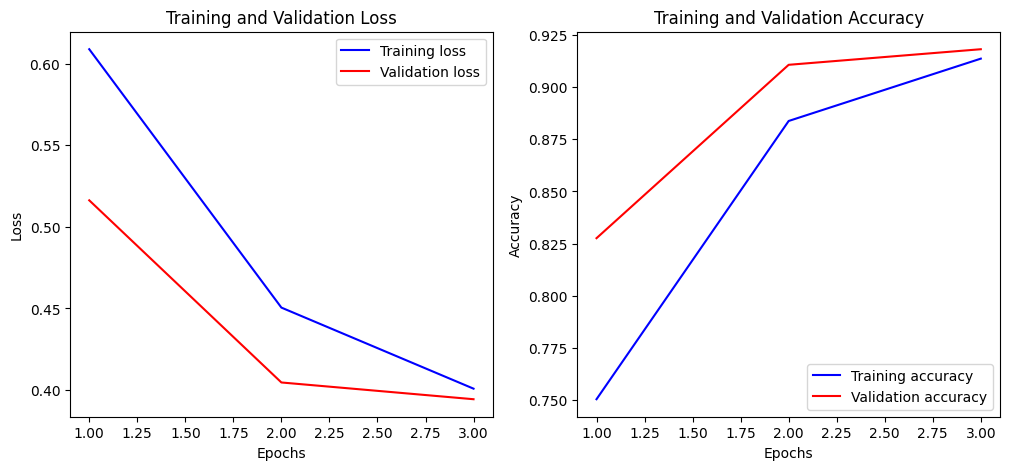

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Evaluate:

Using device: cuda


100%|██████████| 67/67 [00:13<00:00,  5.03it/s]


Accuracy: 0.9192
F1 Score: 0.9192


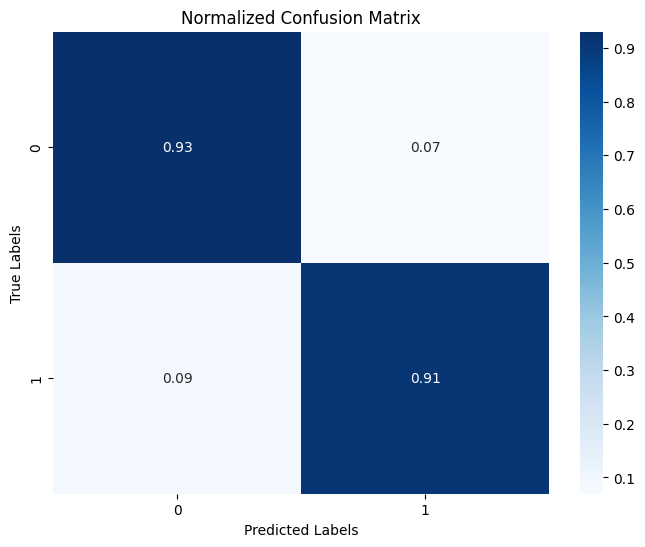

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model5.to(device)
model5.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model5(input_ids, attention_mask, token_type_ids)
        _, predictions = torch.max(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

incorrect_indices = np.where(all_preds != all_labels)[0]

In [41]:
num_samples_to_show = 2
for i in range(min(num_samples_to_show, len(incorrect_indices))):
    idx = incorrect_indices[i]
    sample = test_dataset[idx]

    input_ids = sample[0]
    attention_mask = sample[1]
    token_type_ids = sample[2]
    label = sample[3]

    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)

    print(f"Sample {i+1}:")
    print(f"True label: {label}")
    print(f"Predicted label: {all_preds[idx]}")
    print(f"Original Text: {decoded_text}")
    print("\n" + "-"*50 + "\n")

Sample 1:
True label: 1
Predicted label: 0
Original Text: the government should consider bringing in any new national lockdown rules over christmas rather than now says an oxford university professor https : / / t. co / pdols6cqon

--------------------------------------------------

Sample 2:
True label: 0
Predicted label: 1
Original Text: households should have " required " medical kits with certain items and equipment to treat the different stages of covid - 19.

--------------------------------------------------



### Model Three:

In [43]:
import torch
import torch.nn as nn
from transformers import BertModel

In [44]:
class CTBertBiGRUClassifierFreeze(nn.Module):
    def __init__(self, num_classes=2, gru_hidden_size=128, gru_layers=1, dropout=0.3):
        super(CTBertBiGRUClassifierFreeze, self).__init__()
        self.bert = BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert")

        #Freezing CT-Bert Params
        for param in self.bert.parameters():
            param.requires_grad = False

        self.bigru = nn.GRU(input_size=1024, hidden_size=gru_hidden_size,
                            num_layers=gru_layers, batch_first=True,
                            bidirectional=True, dropout=dropout)

        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

        self.sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = outputs.last_hidden_state

        gru_output, _ = self.bigru(last_hidden_state)

        hidden_state = torch.cat((gru_output[:, -1, :self.bigru.hidden_size], gru_output[:, 0, self.bigru.hidden_size:]), dim=-1)

        hidden_state = self.dropout(hidden_state)

        logits = self.fc(hidden_state)

        probs = self.sigmoid(logits)

        return probs


#### Train:

In [45]:
model6 = CTBertBiGRUClassifierFreeze(num_classes=2)

criterion = nn.CrossEntropyLoss()

epochs = 3
learning_rate = 5e-5
num_epochs = 3
batch_size = 32

optimizer = optim.Adam(model6.parameters(), lr=learning_rate)


model6.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model6.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0

    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model6(input_ids, attention_mask, token_type_ids)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        running_train_correct += (predicted == labels).sum().item()
        running_train_total += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = running_train_correct / running_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model6.eval()
    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0

    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            outputs = model6(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs.squeeze(), labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_val_correct += (predicted == labels).sum().item()
            running_val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = running_val_correct / running_val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training finished!")

epochs = range(1, num_epochs + 1)


config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Training Loss: 0.5828, Training Accuracy: 0.8045
Epoch 1, Validation Loss: 0.4802, Validation Accuracy: 0.9033
Epoch 2, Training Loss: 0.4391, Training Accuracy: 0.9240
Epoch 2, Validation Loss: 0.3945, Validation Accuracy: 0.9369
Epoch 3, Training Loss: 0.3779, Training Accuracy: 0.9466
Epoch 3, Validation Loss: 0.3691, Validation Accuracy: 0.9491
Training finished!


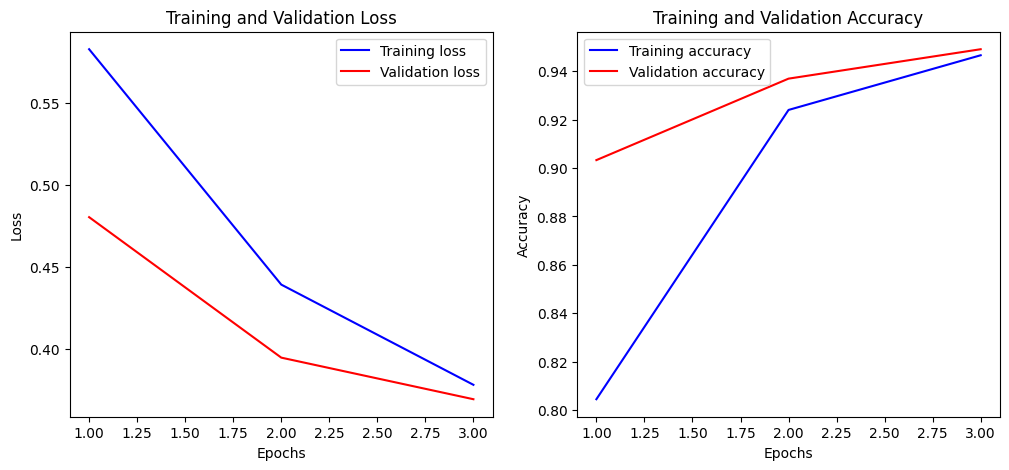

In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Evaluation:

Using device: cuda


100%|██████████| 67/67 [00:44<00:00,  1.51it/s]


Accuracy: 0.9486
F1 Score: 0.9485


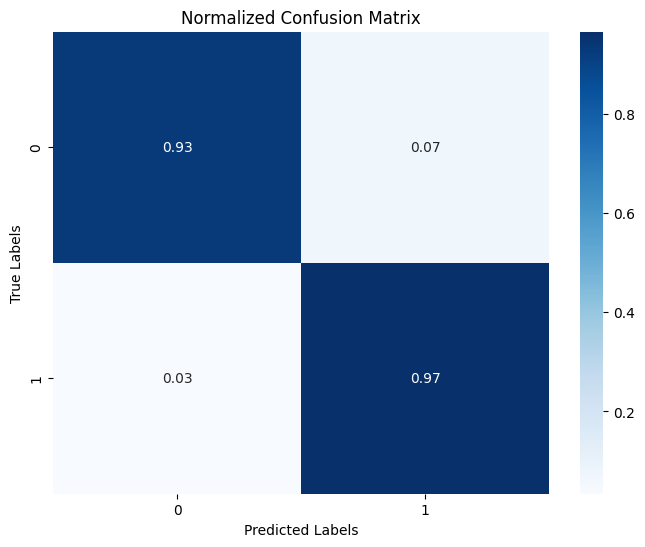

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model6.to(device)
model6.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model6(input_ids, attention_mask, token_type_ids)
        _, predictions = torch.max(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

incorrect_indices = np.where(all_preds != all_labels)[0]

In [48]:
num_samples_to_show = 2
for i in range(min(num_samples_to_show, len(incorrect_indices))):
    idx = incorrect_indices[i]
    sample = test_dataset[idx]

    input_ids = sample[0]
    attention_mask = sample[1]
    token_type_ids = sample[2]
    label = sample[3]

    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)

    print(f"Sample {i+1}:")
    print(f"True label: {label}")
    print(f"Predicted label: {all_preds[idx]}")
    print(f"Original Text: {decoded_text}")
    print("\n" + "-"*50 + "\n")

Sample 1:
True label: 0
Predicted label: 1
Original Text: two interesting correlations : 1 ) children tend to weather covid - 19 pretty well ; they also get a ton of vitamin d. 2 ) black people are getting slammed by covid - 19 ; black people also have much higher instances of vitamin d deficiency ( 76 % vs 40 % in the general population ).

--------------------------------------------------

Sample 2:
True label: 0
Predicted label: 1
Original Text: govt has added # corona disease in all existing mediclaim insurances as a special case # covid2019india https : / / t. co / 39vpw7tbqq

--------------------------------------------------

